In [2]:
pip install gym numpy matplotlib

   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 399.6 kB/s eta 0:00:19
   -- ------------------------------------- 0.5/7.8 MB 399.6 kB/s eta 0:00:19
   ---- ----------------------------------- 0.8/7.8 MB 419.4 kB/s eta 0:00:17
   ---- ----------------------------------- 0.8/7.8 MB 419.4 kB/s eta 0:00:17
   ---- ----------------------------------- 0.8/7.8 MB 419.4 kB/s eta 0:00:17
   --------- ------------------------------ 1.8/7.8 MB 846.1 kB/s eta 0:00:08
   ----------------- ---------------------- 3.4/7.8 MB 1.5 MB/s eta 0:00:03
   ------------------------- -------------

In [13]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time

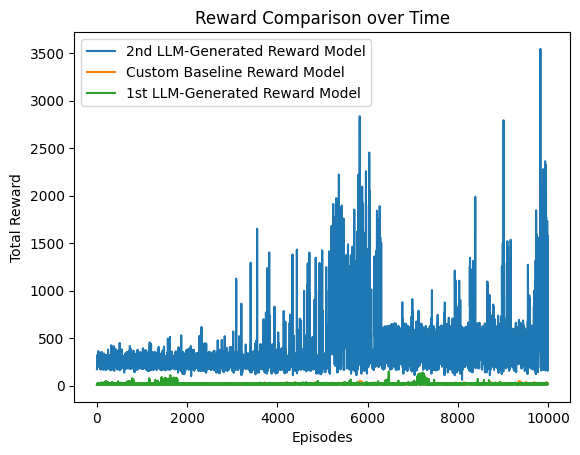

In [18]:
# Q-Learning agent
class QLearningAgent:
    def __init__(self, env, n_bins=10, learning_rate=0.1, discount_factor=0.99, epsilon=0.1):
        self.env = env
        self.n_bins = n_bins
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon


        self.bins = [
            np.linspace(-4.8, 4.8, self.n_bins),  # Position
            np.linspace(-5, 5, self.n_bins),      # Velocity
            np.linspace(-0.418, 0.418, self.n_bins),  # Angle
            np.linspace(-5, 5, self.n_bins)       # Angular velocity
        ]

        # Initialize Q-table with zeros
        self.q_table = np.zeros((self.n_bins, self.n_bins, self.n_bins, self.n_bins, env.action_space.n))

    def discretize(self, observation):
        # Discretize each dimension of the observation
        state = []
        for i, obs in enumerate(observation):
            state.append(np.digitize(obs, self.bins[i]) - 1)
        return tuple(state)

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:  # Exploitation
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error


#---

# Baseline SoTA reward function
def SoTARewardFunction(observation, action):
    x, _, theta, _ = observation
    
    if abs(theta) > np.deg2rad(15) or abs(x) > 2.4:
        return 0
    
    return 1

# Example LLM-generated reward functions
def LLMRewardFunction1(observation, action):
    x, _, angle, _ = observation
    reward = 1.0 - abs(angle) - 0.5 * abs(x)
    return max(0, reward)

def LLMRewardFunction2(observation, action):
    x, _, angle, _ = observation
    reward = 1.0
    
    if abs(x) > 2.4 or abs(angle) > 0.2:
        reward = -10.0
    else:
        reward += 10.0 / (1.0 + abs(angle))
        reward += 5.0 / (1.0 + abs(x))
    
    return int(reward)


#---

# Train the agent using Q-learning
def train(env, agent, reward_model, episodes=500):
    rewards = []
    for episode in range(episodes):
        observation = env.reset()[0]
        state = agent.discretize(observation)
        total_reward = 0
        done = False
        while not done:
            action = agent.choose_action(state)
            next_observation, reward, done, _, _ = env.step(action)
            adjusted_reward = reward_model(next_observation, reward)
            next_state = agent.discretize(next_observation)
            agent.update(state, action, adjusted_reward, next_state)
            state = next_state
            total_reward += adjusted_reward
        rewards.append(total_reward)
    return rewards



# # Set up the environment and agent
# env = gym.make('CartPole-v1')
# agent = QLearningAgent(env)



# episodes = 10000
# baselineRewards = train(env, agent, SoTARewardFunction, episodes)
# LLM1Rewards = train(env, agent, LLMRewardFunction1, episodes)
# LLM2Rewards = train(env, agent, LLMRewardFunction2, episodes)

# # Plot results
# plt.plot(np.arange(episodes), LLM2Rewards, label="2nd LLM-Generated Reward Model")
# plt.plot(np.arange(episodes), baselineRewards, label="Custom Baseline Reward Model")
# plt.plot(np.arange(episodes), LLM1Rewards, label="1st LLM-Generated Reward Model")

# plt.xlabel("Episodes")
# plt.ylabel("Total Reward")

# plt.title("Reward Comparison over Time")

# plt.legend()
# plt.show()


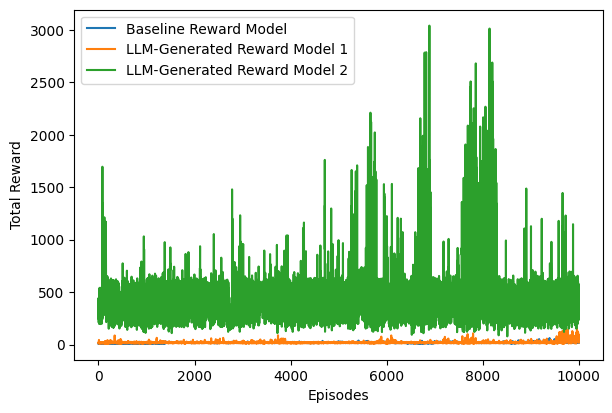

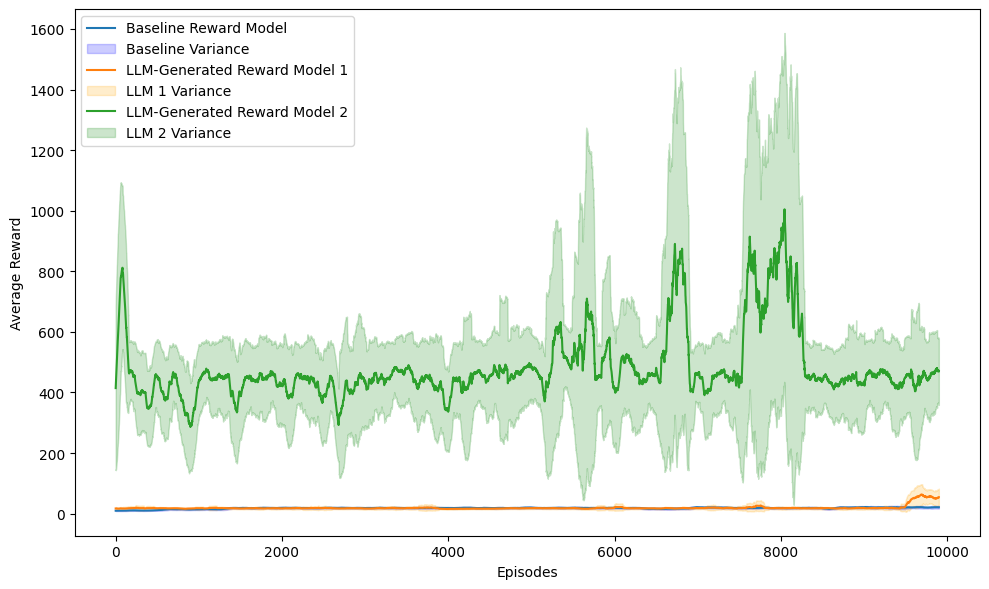

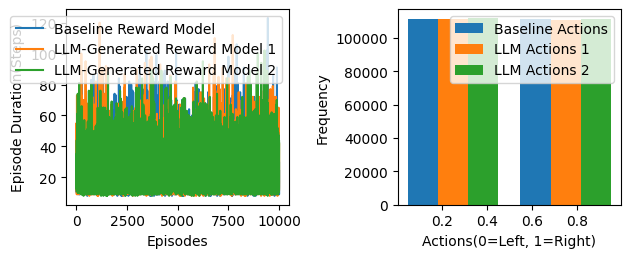

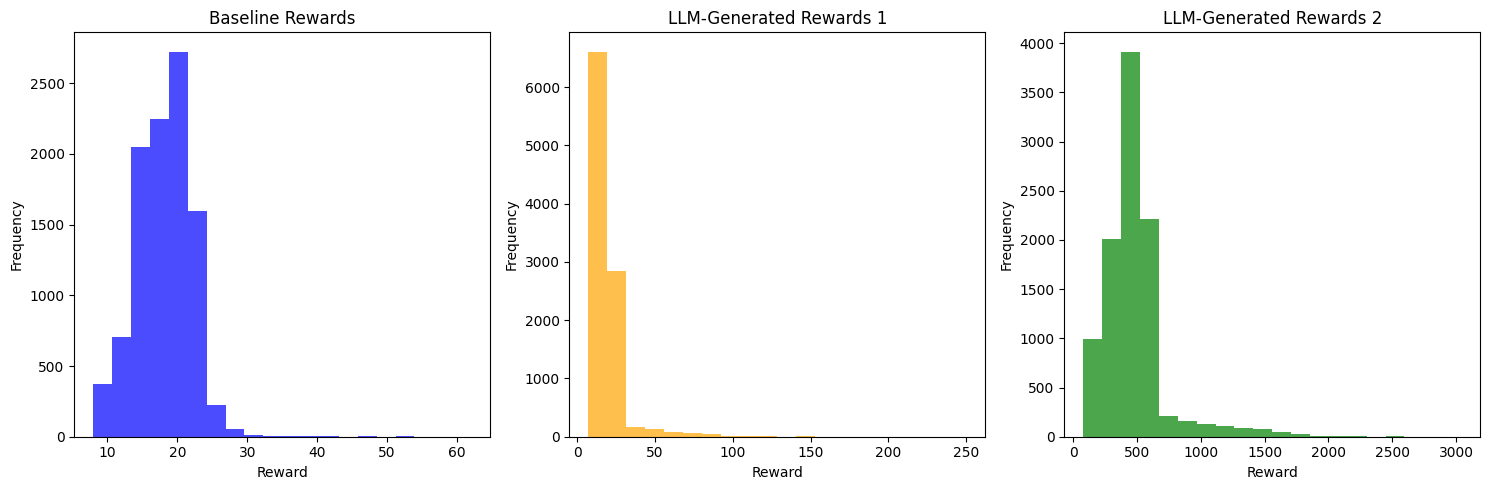

Baseline Success Rate: 0.00%
LLM-Generated Success Rate 1: 0.01%
LLM-Generated Success Rate 2: 94.15%


In [32]:
# Takes ~ 60 second to run

env = gym.make('CartPole-v1')
agent = QLearningAgent(env)



def movingAverageAndStd(data, windowSize=100):
    average = np.convolve(data, np.ones(windowSize) / windowSize, mode='valid')
    std = [np.std(data[i:i+windowSize]) for i in range(len(data) - windowSize + 1)]
    return average, std




episodes = 10000
baselineRewards = train(env, agent, SoTARewardFunction, episodes)
LLM1Rewards = train(env, agent, LLMRewardFunction1, episodes)
LLM2Rewards = train(env, agent, LLMRewardFunction2, episodes)


plt.figure(figsize=(15, 10))


#Total Reward Comparison
plt.subplot(2, 2, 1)
plt.plot(np.arange(episodes), baselineRewards, label="Baseline Reward Model")
plt.plot(np.arange(episodes), LLM1Rewards, label="LLM-Generated Reward Model 1")
plt.plot(np.arange(episodes), LLM2Rewards, label="LLM-Generated Reward Model 2")


plt.xlabel("Episodes")
plt.ylabel("Total Reward")

plt.legend()

# 2.Running Average of Rewards

avgBaseline, stdBaseline = movingAverageAndStd(baselineRewards, windowSize=100)
avgLLM1, stdLLM1 = movingAverageAndStd(LLM1Rewards, windowSize=100)
avgLLM2, stdLLM2 = movingAverageAndStd(LLM2Rewards, windowSize=100)

plt.figure(figsize=(10, 6))


plt.plot(np.arange(len(avgBaseline)), avgBaseline, label="Baseline Reward Model")
plt.fill_between(np.arange(len(avgBaseline)), avgBaseline - stdBaseline, avgBaseline + stdBaseline, color='blue', alpha=0.2, label="Baseline Variance")


plt.plot(np.arange(len(avgLLM1)), avgLLM1, label="LLM-Generated Reward Model 1")
plt.fill_between(np.arange(len(avgLLM1)), avgLLM1 - stdLLM1, avgLLM1 + stdLLM1, color='orange', alpha=0.2, label="LLM 1 Variance")


plt.plot(np.arange(len(avgLLM2)), avgLLM2, label="LLM-Generated Reward Model 2")
plt.fill_between(np.arange(len(avgLLM2)), avgLLM2 - stdLLM2, avgLLM2 + stdLLM2, color='green', alpha=0.2, label="LLM 2 Variance")

plt.xlabel("Episodes")
plt.ylabel("Average Reward")


plt.legend()
plt.tight_layout()
plt.show()

# 3. Episode Duration
def episodeDuration(env, rewardModel, episodes=500):
    durations = []
    for episode in range(episodes):
        observation = env.reset()
        done = False
        duration = 0

        while not done:
            action = env.action_space.sample()
            observation, reward, done, _, _ = env.step(action)
            duration += 1  
        durations.append(duration)

    return durations

# Get the episode durations
baselineDurations = episodeDuration(env, SoTARewardFunction, episodes)
llmDurations1 = episodeDuration(env, LLMRewardFunction1, episodes)
llmDurations2 = episodeDuration(env, LLMRewardFunction2, episodes)

# Plot Episode Duration
plt.subplot(2, 2, 3)
plt.plot(np.arange(episodes), baselineDurations, label="Baseline Reward Model")
plt.plot(np.arange(episodes), llmDurations1, label="LLM-Generated Reward Model 1")
plt.plot(np.arange(episodes), llmDurations2, label="LLM-Generated Reward Model 2")


plt.xlabel("Episodes")
plt.ylabel("Episode Duration(Steps)")
plt.legend()

# 4.action distribution
def getActionDistribution(env, rewardModel, episodes):
    actions = []
    for episode in range(episodes):
        observation = env.reset()
        done = False

        while not done:
            action = env.action_space.sample() 
            actions.append(action)
            observation, _, done, _, _ = env.step(action)

    return actions

baselineActions = getActionDistribution(env, SoTARewardFunction, episodes)
llmActions1 = getActionDistribution(env, LLMRewardFunction1, episodes)
llmActions2 = getActionDistribution(env, LLMRewardFunction2, episodes)

plt.subplot(2, 2, 4)
plt.hist([baselineActions, llmActions1, llmActions2], label=["Baseline Actions", "LLM Actions 1", "LLM Actions 2"], bins=2)

plt.xlabel("Actions(0=Left, 1=Right)")
plt.ylabel("Frequency")

plt.legend()
plt.tight_layout()
plt.show()

# 5. Reward Distribution
plt.figure(figsize=(15, 5))

# Plot for Baseline Rewards
plt.subplot(1, 3, 1)  
plt.hist(baselineRewards, bins=20, alpha=0.7, color='blue')
plt.title("Baseline Rewards")
plt.xlabel("Reward")
plt.ylabel("Frequency")

# Plot for LLM-Generated Rewards 1
plt.subplot(1, 3, 2)  
plt.hist(LLM1Rewards, bins=20, alpha=0.7, color='orange')
plt.title("LLM-Generated Rewards 1")
plt.xlabel("Reward")
plt.ylabel("Frequency")

# Plot for LLM-Generated Rewards 2
plt.subplot(1, 3, 3)
plt.hist(LLM2Rewards, bins=20, alpha=0.7, color='green')
plt.title("LLM-Generated Rewards 2")
plt.xlabel("Reward")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# 6. Success Rate Calc
# successThreshold = 200

# baselineSuccessRate = sum([1 if r >= successThreshold else 0 for r in baselineRewards]) / episodes
# llmSuccessRate1 = sum([1 if r >= successThreshold else 0 for r in LLM1Rewards]) / episodes
# llmSuccessRate2 = sum([1 if r >= successThreshold else 0 for r in LLM2Rewards]) / episodes

# print(f"Baseline Success Rate: {baselineSuccessRate * 100:.2f}%")
# print(f"LLM-Generated Success Rate 1: {llmSuccessRate1 * 100:.2f}%")
# print(f"LLM-Generated Success Rate 2: {llmSuccessRate2 * 100:.2f}%")



In [35]:



def visualizeSuccessfulRuns(env, rewards, durations, rewardModelName, agent):
    
    longest_runs_indices = np.argsort(durations)[-20:]  # Get the indices of the top 20 longest runs

    env = gym.make('CartPole-v1', render_mode="human")
    agent = QLearningAgent(env)

    for idx in longest_runs_indices:
        print(f"Duration: {durations[idx]}, Reward: {rewards[idx]}")



        observation, _ = env.reset()
        state = agent.discretize(observation)
        done = False


        print(f"{rewardModelName} - Run {idx+1}")

        while not done:
            action = agent.choose_action(state)
            next_observation, reward, done, _, _ = env.step(action)
            next_state = agent.discretize(next_observation)
            state = next_state

            # Render environment
            env.render()

            time.sleep(0.01)

        # print(f"{rewardModelName} - Run {idx+1}")

    env.close()




visualizeSuccessfulRuns(env, baselineRewards, baselineDurations, "Baseline", agent)
visualizeSuccessfulRuns(env, LLM1Rewards, llmDurations1, "LLMRewardFunction1", agent)
visualizeSuccessfulRuns(env, LLM2Rewards, llmDurations2, "LLMRewardFunction2", agent)


Duration: 86, Reward: 22
Baseline - Run 4257
Duration: 86, Reward: 19
Baseline - Run 9705
Duration: 86, Reward: 12
Baseline - Run 1299
Duration: 87, Reward: 21
Baseline - Run 4330
Duration: 87, Reward: 12
Baseline - Run 1075
Duration: 88, Reward: 23
Baseline - Run 9440
Duration: 88, Reward: 16
Baseline - Run 7816
Duration: 88, Reward: 10
Baseline - Run 254
Duration: 89, Reward: 19
Baseline - Run 4359
Duration: 90, Reward: 19
Baseline - Run 7231
Duration: 91, Reward: 15
Baseline - Run 8262
Duration: 91, Reward: 20
Baseline - Run 9896
Duration: 91, Reward: 22
Baseline - Run 3124
Duration: 98, Reward: 18
Baseline - Run 7499
Duration: 99, Reward: 23
Baseline - Run 3940
Duration: 102, Reward: 20
Baseline - Run 4916
Duration: 102, Reward: 22
Baseline - Run 3447
Duration: 102, Reward: 19
Baseline - Run 9387
Duration: 106, Reward: 16
Baseline - Run 7909
Duration: 123, Reward: 23
Baseline - Run 9448
Duration: 86, Reward: 18.499337770044804
LLMRewardFunction1 - Run 4638
Duration: 87, Reward: 18.

In [ ]:
#Maybe run many instances of reward models generated by Claude. Compare, with SoTA as baseline